In [1]:
# Chosen using results from Iris-K
epsilon = 0.75
k = 1

input_dim = 4
num_clusters = 3
num_classes = 3

model_file = "Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt"

feature_names = ["Sepal Length", "Sepal Width", "Petal Length", "Petal Width"]
import csv
import json
import numpy as np
import os
import pandas as pd

os.system("rm *.png")

import sys
sys.path.insert(0, "../Code/")
from explain_cs import explain
from load_scvis import load_vae
from metrics import metrics, eval_epsilon
from myplot import plot_polys, plot_groups, plot_metrics, plot_explanation, plot_change
from misc import poly2labels

def load_model(input_dim = input_dim, model_file = model_file):
    return load_vae(input_dim, model_file)


In [2]:
# Load Data & Configuration

x = pd.read_csv("Data/X.tsv", sep="\t").values

y = pd.read_csv("Data/y.tsv", sep="\t").values


with open("vertices.json") as json_file:  
    all_vertices = json.load(json_file)


[Text(133.92000000000002, 181.2, 'X[2] <= 0.246\ngini = 0.667\nsamples = 149\nvalue = [49, 50, 50]'),
 Text(66.96000000000001, 108.72, 'gini = 0.0\nsamples = 49\nvalue = [49, 0, 0]'),
 Text(200.88000000000002, 108.72, 'X[3] <= 0.688\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(133.92000000000002, 36.23999999999998, 'gini = 0.168\nsamples = 54\nvalue = [0, 49, 5]'),
 Text(267.84000000000003, 36.23999999999998, 'gini = 0.043\nsamples = 46\nvalue = [0, 1, 45]')]

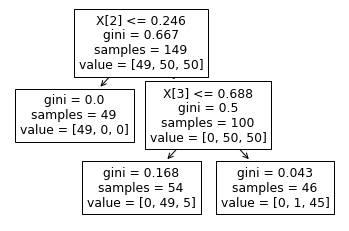

In [3]:
# Find a simple Decision Tree for this dataset

from sklearn import tree

clf = tree.DecisionTreeClassifier(max_depth = 2)

clf = clf.fit(x, y)
tree.plot_tree(clf)  


In [4]:
# Calculate Data Representation

sess, rep, X, D = load_model()

data_rep = sess.run(rep, feed_dict={X: x, D: np.zeros((1, input_dim))})

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


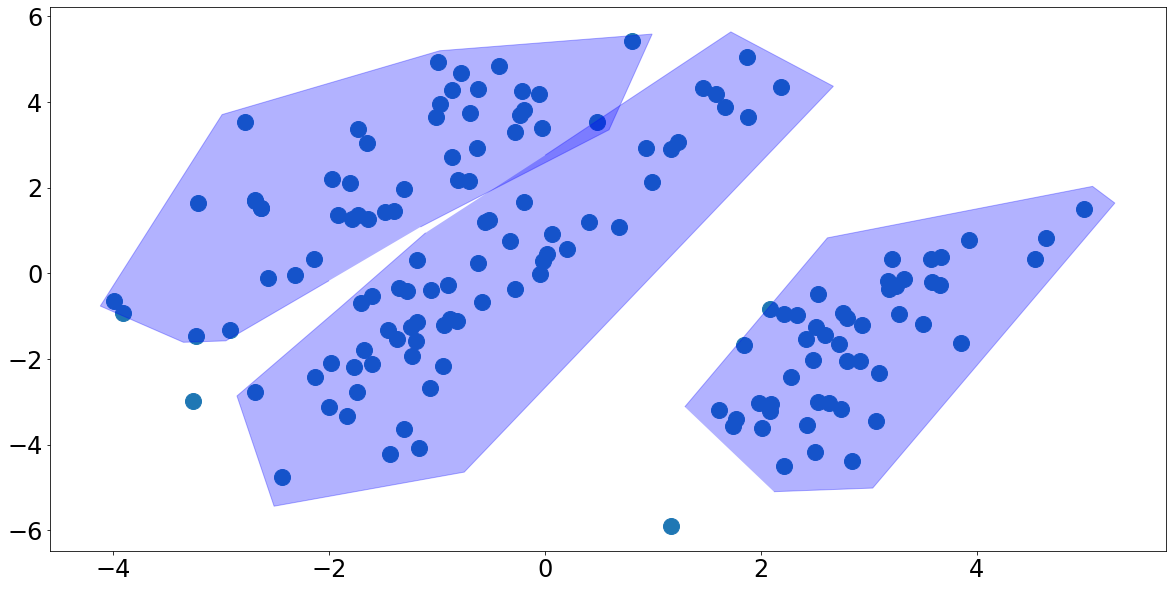

In [5]:
# Visualize the data and the marked clusters

plot_polys(data_rep, all_vertices)

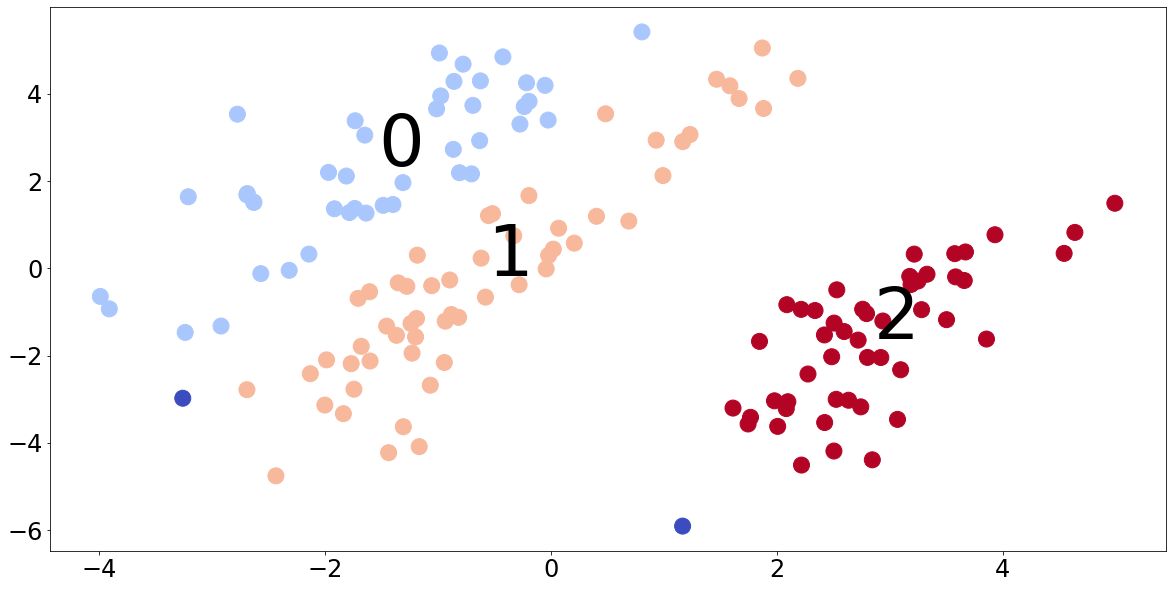

In [6]:
# Visualize the clusters in the learned representation

labels = poly2labels(data_rep, all_vertices)

means, centers, indices = plot_groups(x, data_rep, num_clusters, labels, name = "iris-rep.png")


In [7]:
# Inspect the correlation between cluster and class

confusion  = np.zeros((num_clusters, num_classes))
for i in range(y.shape[0]):
    if labels[i] != -1.0:
        confusion[int(labels[i]), int(y[i])] += 1
    
print(confusion)

[[ 0.  5. 38.]
 [ 0. 44. 12.]
 [48.  0.  0.]]


INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


../Code/myplot.py:105: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  ax.cax.colorbar(im)
/home/roel/.pyenv/versions/3.8.0/lib/python3.8/site-packages/mpl_toolkits/axes_grid1/axes_grid.py:51: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from .colorbar import Colorbar


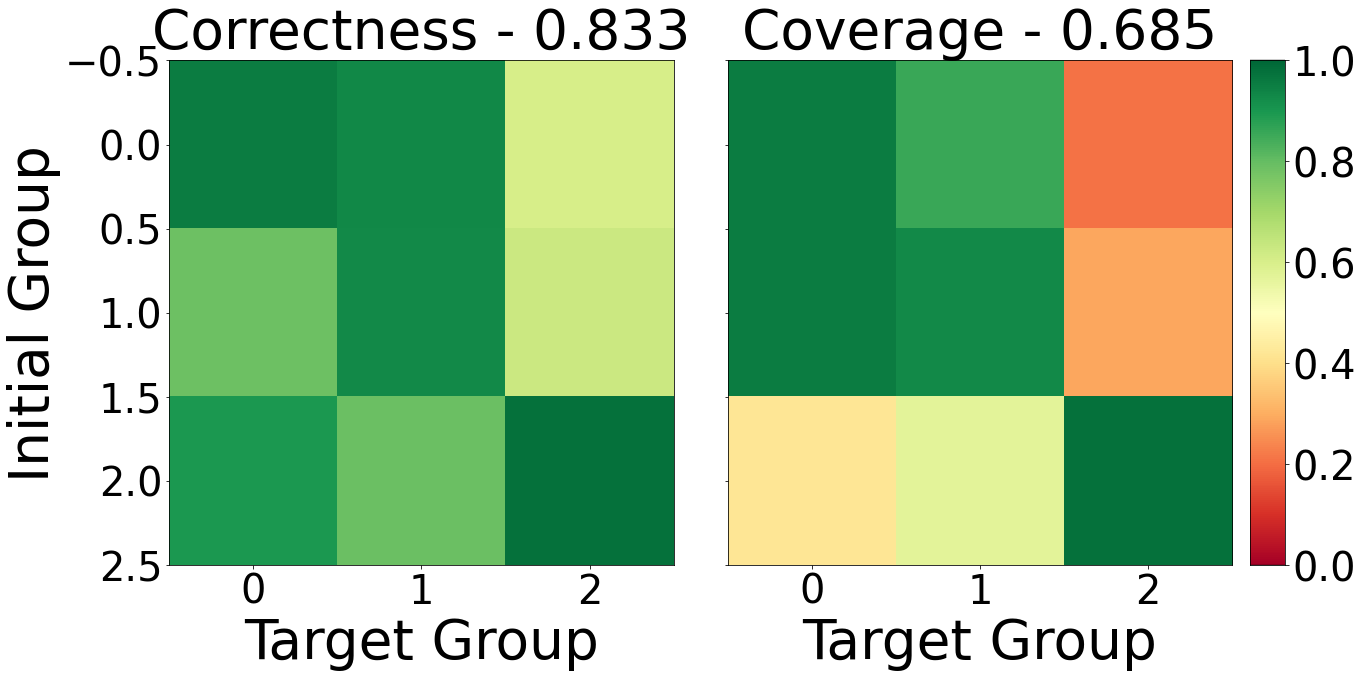

INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


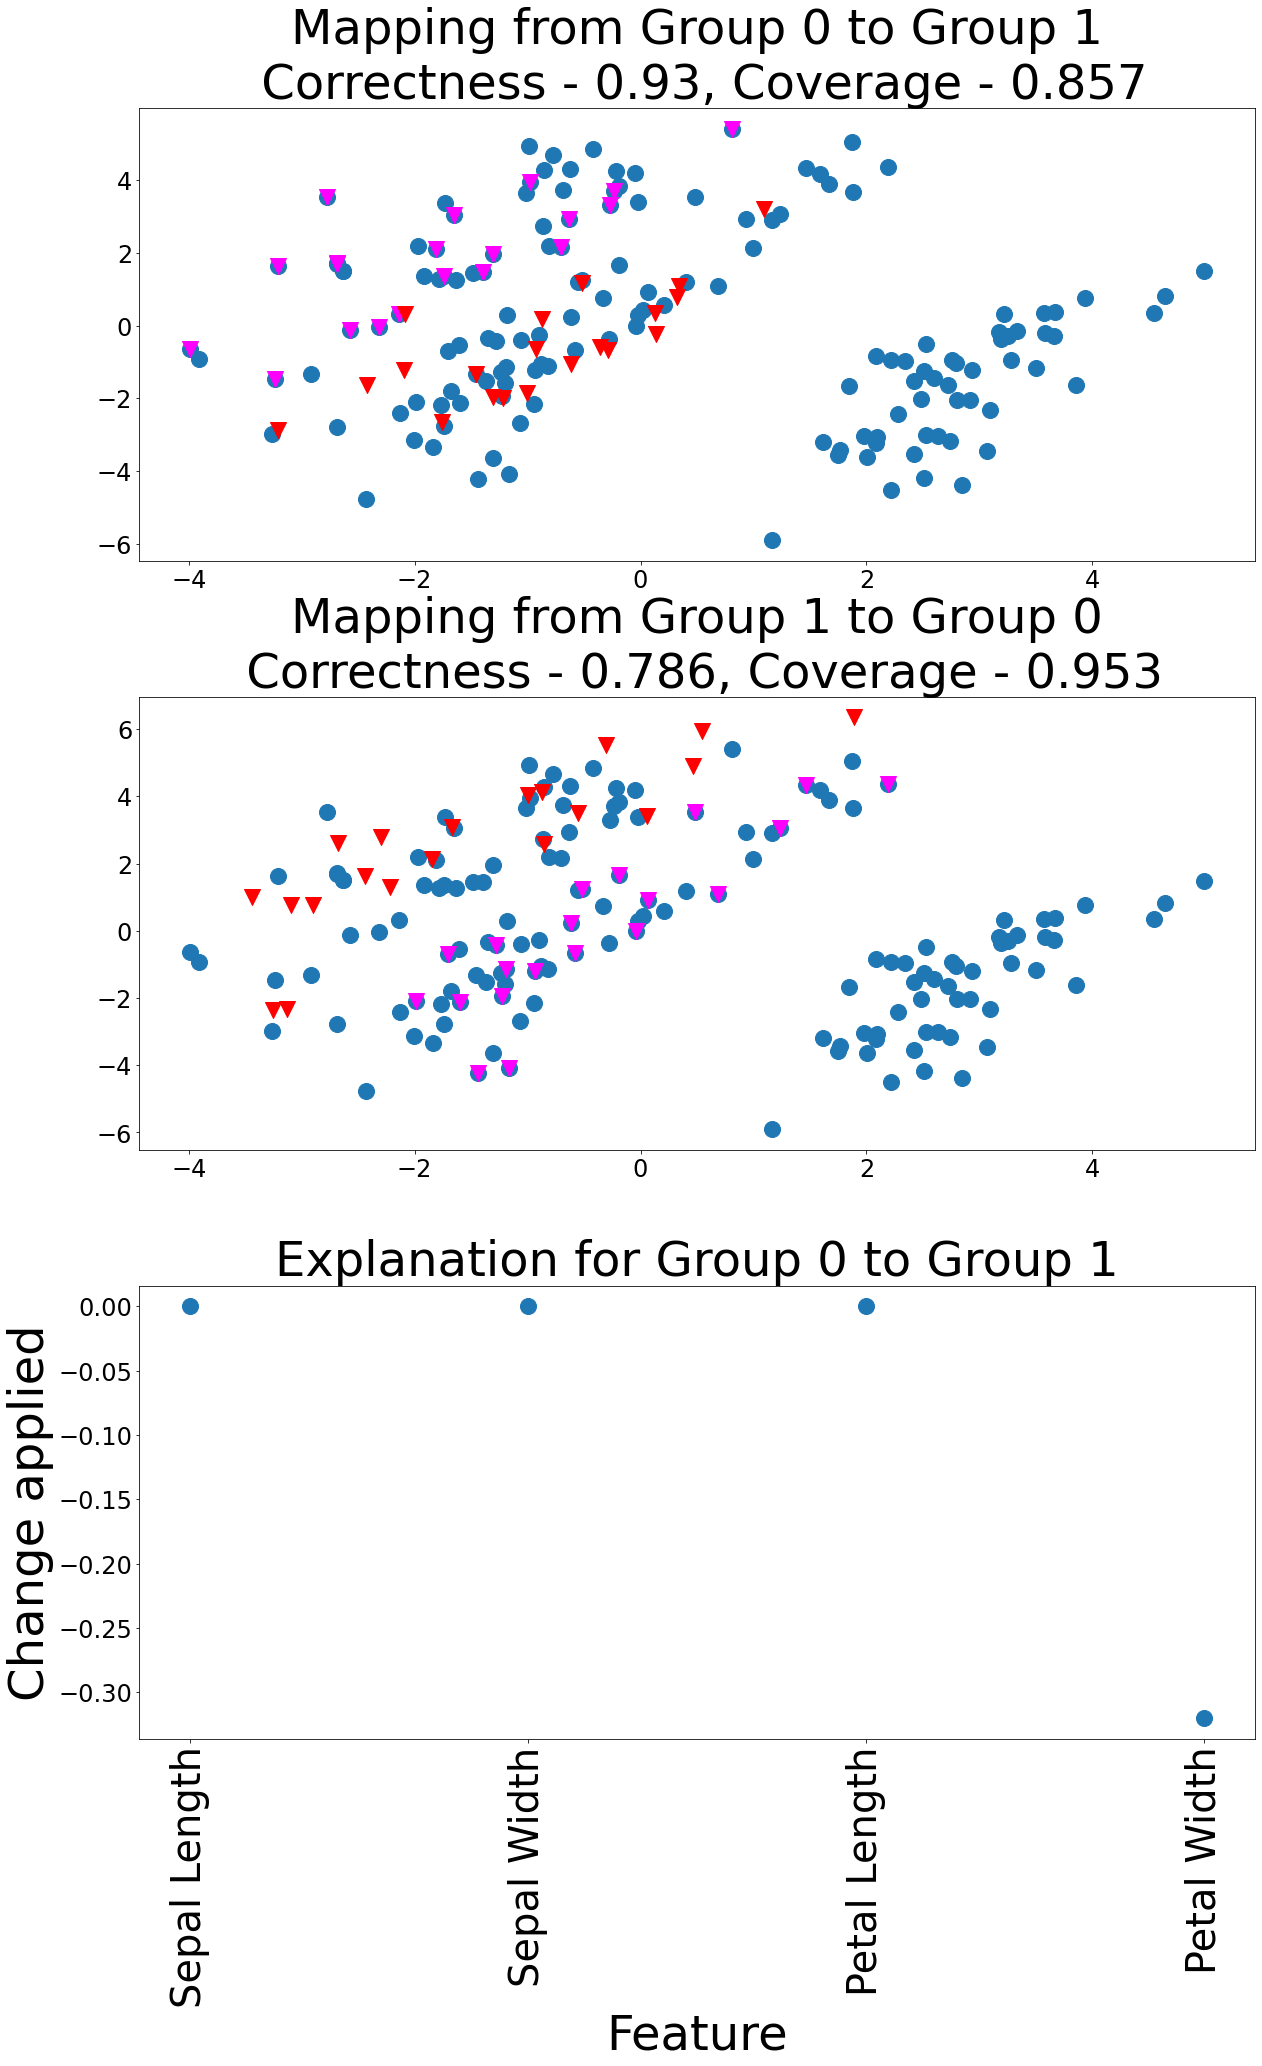

INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


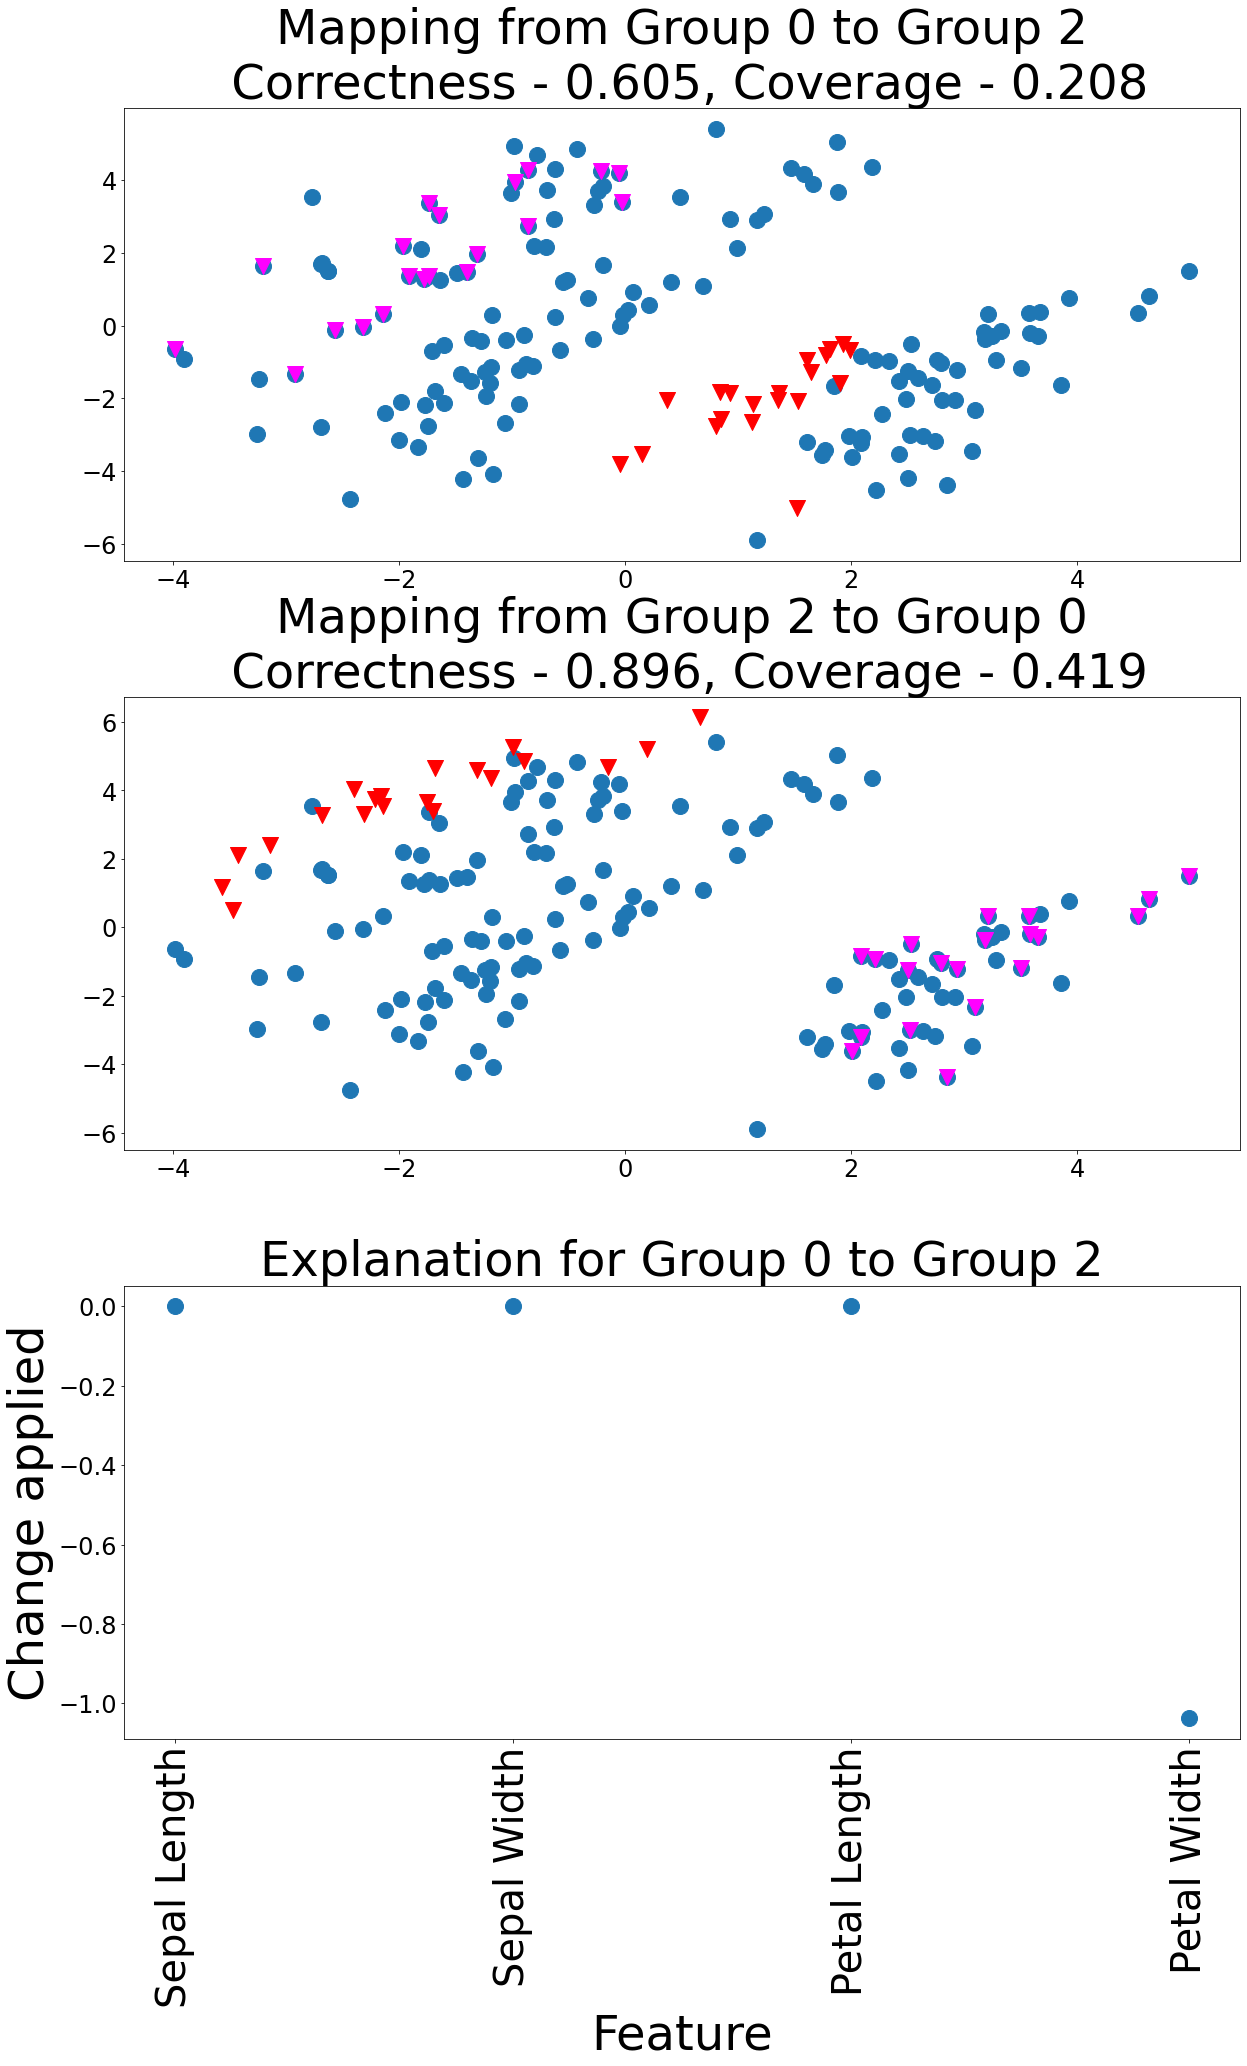

INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


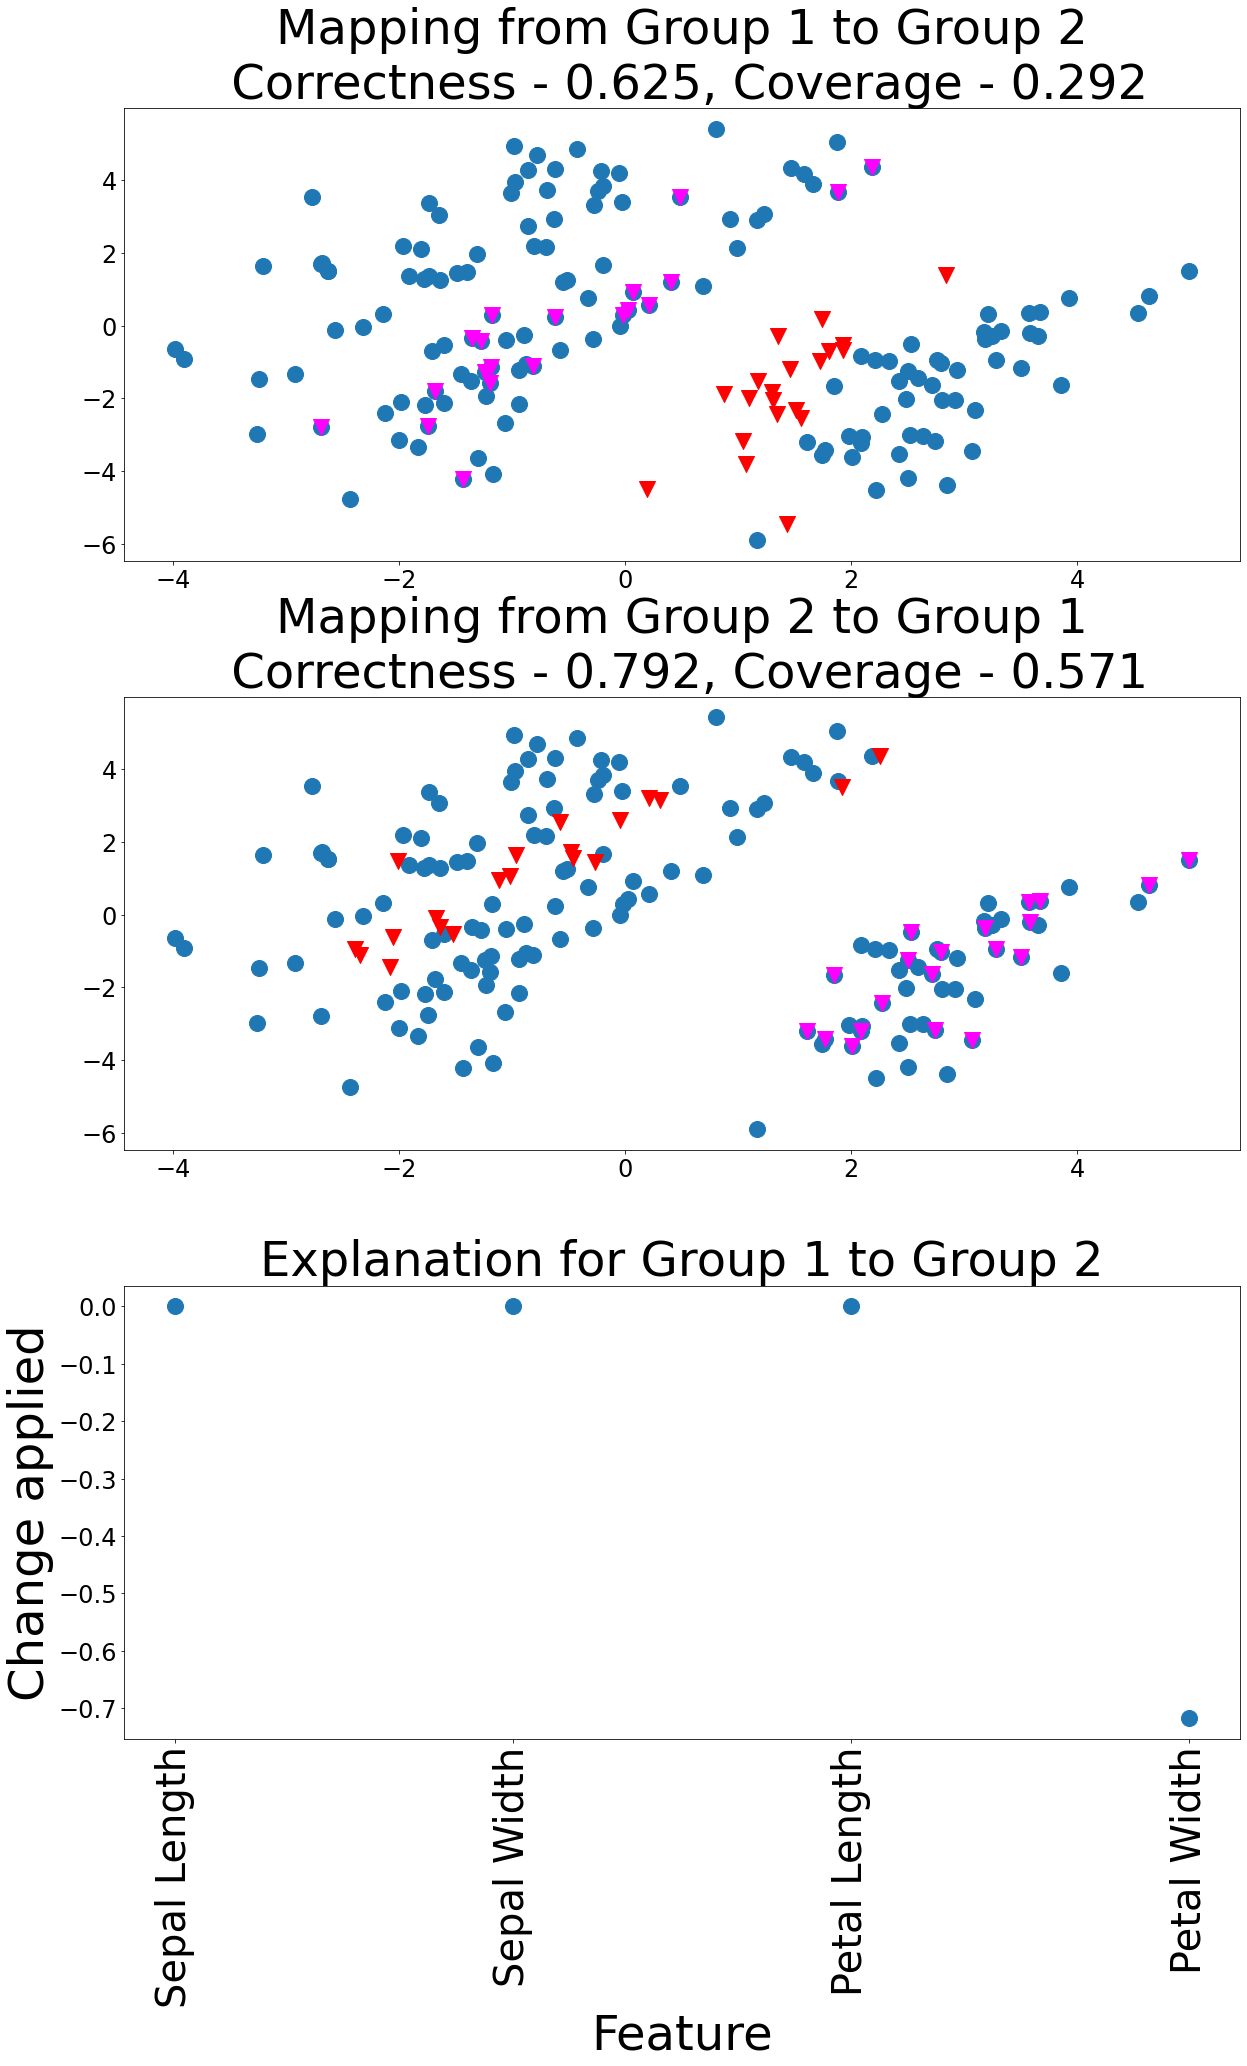

In [8]:
# Evaluate the explanations

deltas = np.load("../Iris-K/deltas" + str(k) + ".npy")

a, b = metrics(load_model, x, indices, deltas, epsilon, k = k)

plot_metrics(a, b, name = "iris-metrics.png")

plot_explanation(load_model, x, data_rep, indices, deltas, a, b, 0, 1, k = k, name = "iris-0to1.png", num_points = 20, feature_names = feature_names)

plot_explanation(load_model, x, data_rep, indices, deltas, a, b, 0, 2, k = k,  name = "iris-0to2.png", num_points = 20, feature_names = feature_names)

plot_explanation(load_model, x, data_rep, indices, deltas, a, b, 1, 2, k = k,  name = "iris-1to2.png", num_points = 20, feature_names = feature_names)


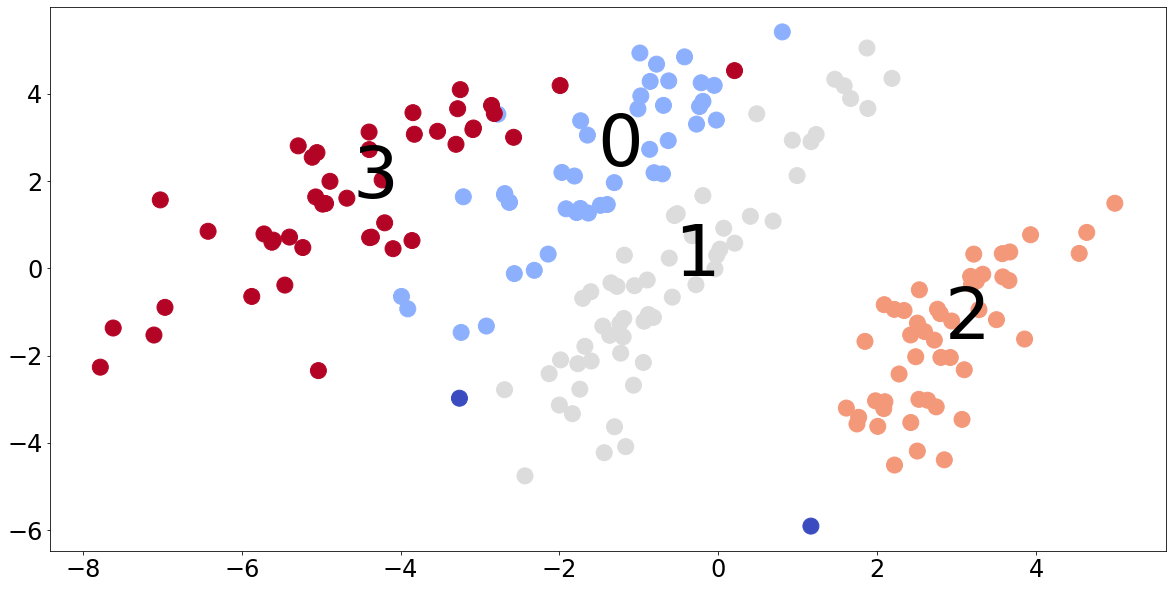

In [9]:
# Let's "corrupt" one of the groups

corrupt = False
target_corrupted = 0

if corrupt:

    indices_corrupted = np.where(labels == target_corrupted)
    n_corrupted = len(indices_corrupted[0])

    x_corrupted = x[indices_corrupted]
    x_corrupted[:, 1] -= 0.4 + np.random.uniform(low = -0.1, high = 0.1, size = n_corrupted)

    print(x_corrupted[:, 1])

    x_full = np.vstack((x, x_corrupted))

    np.savetxt("Data/X_corrupted.tsv", x_full, delimiter = "\t")

    labels_full = np.vstack((np.expand_dims(labels, 1), num_clusters * np.ones((n_corrupted,1))))

    np.savetxt("Data/labels_corrupted.tsv", labels_full, delimiter = "\t")
else:
    x_full = np.loadtxt("Data/X_corrupted.tsv", delimiter = "\t")
    labels_full = np.loadtxt("Data/labels_corrupted.tsv", delimiter = "\t")    

# Compute the new representation
data_rep_full = sess.run(rep, feed_dict={X: x_full, D: np.zeros((1, input_dim))})

# Visualize the clusters in the learned representation
means_full, centers_full, indices_full = plot_groups(x_full, data_rep_full, num_clusters + 1, labels_full, name = "iris-rep-corrupted.png")



In [10]:
# Compute the group explanations

run = False

if run:
    os.system("rm deltas_corrupted.npy")
    
    best_val = 0.0
    for lg in [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]:
        for trial in range(5):

            deltas = explain(load_model, means_full, centers_full, learning_rate = 0.01, consecutive_steps = 5, lambda_global = lg)
            a, b = metrics(load_model, x_full, indices, deltas, epsilon, k = k) 

            val = np.mean(a)

            if val > best_val:
                best_val = val
                np.save("deltas_corrupted.npy", deltas)

            os.system("rm -rf explanation")

INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


../Code/myplot.py:105: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  ax.cax.colorbar(im)


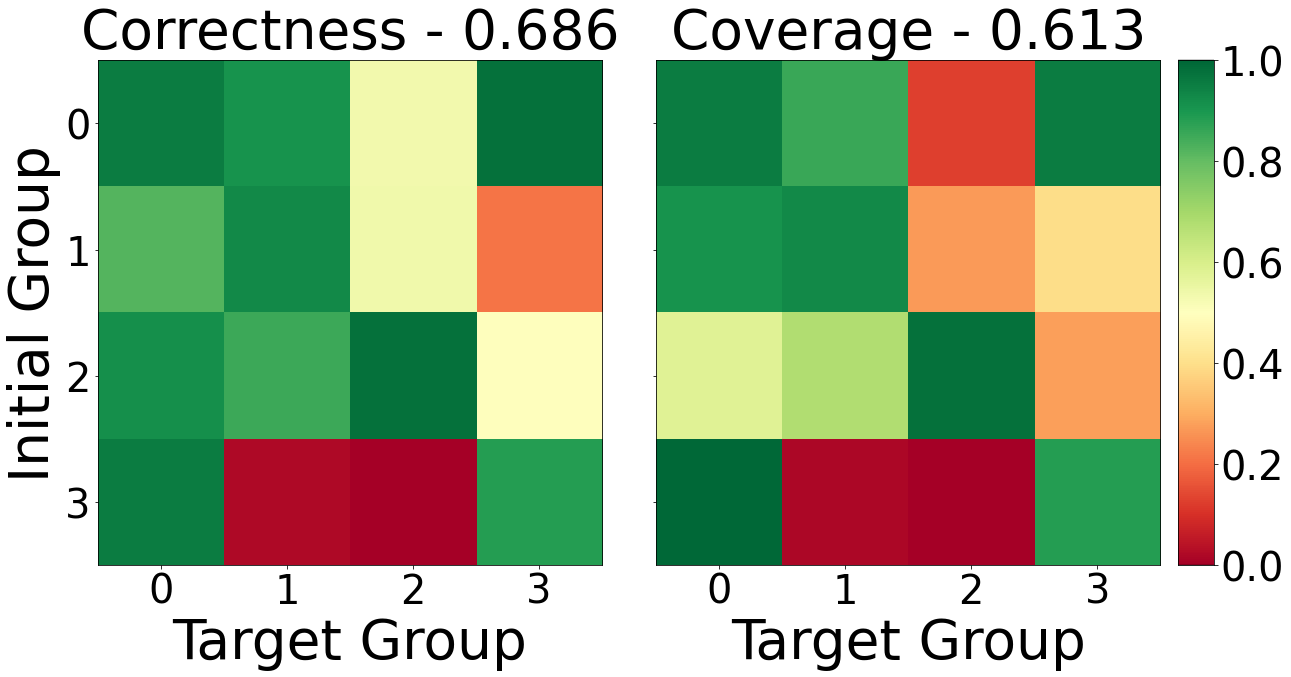

INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


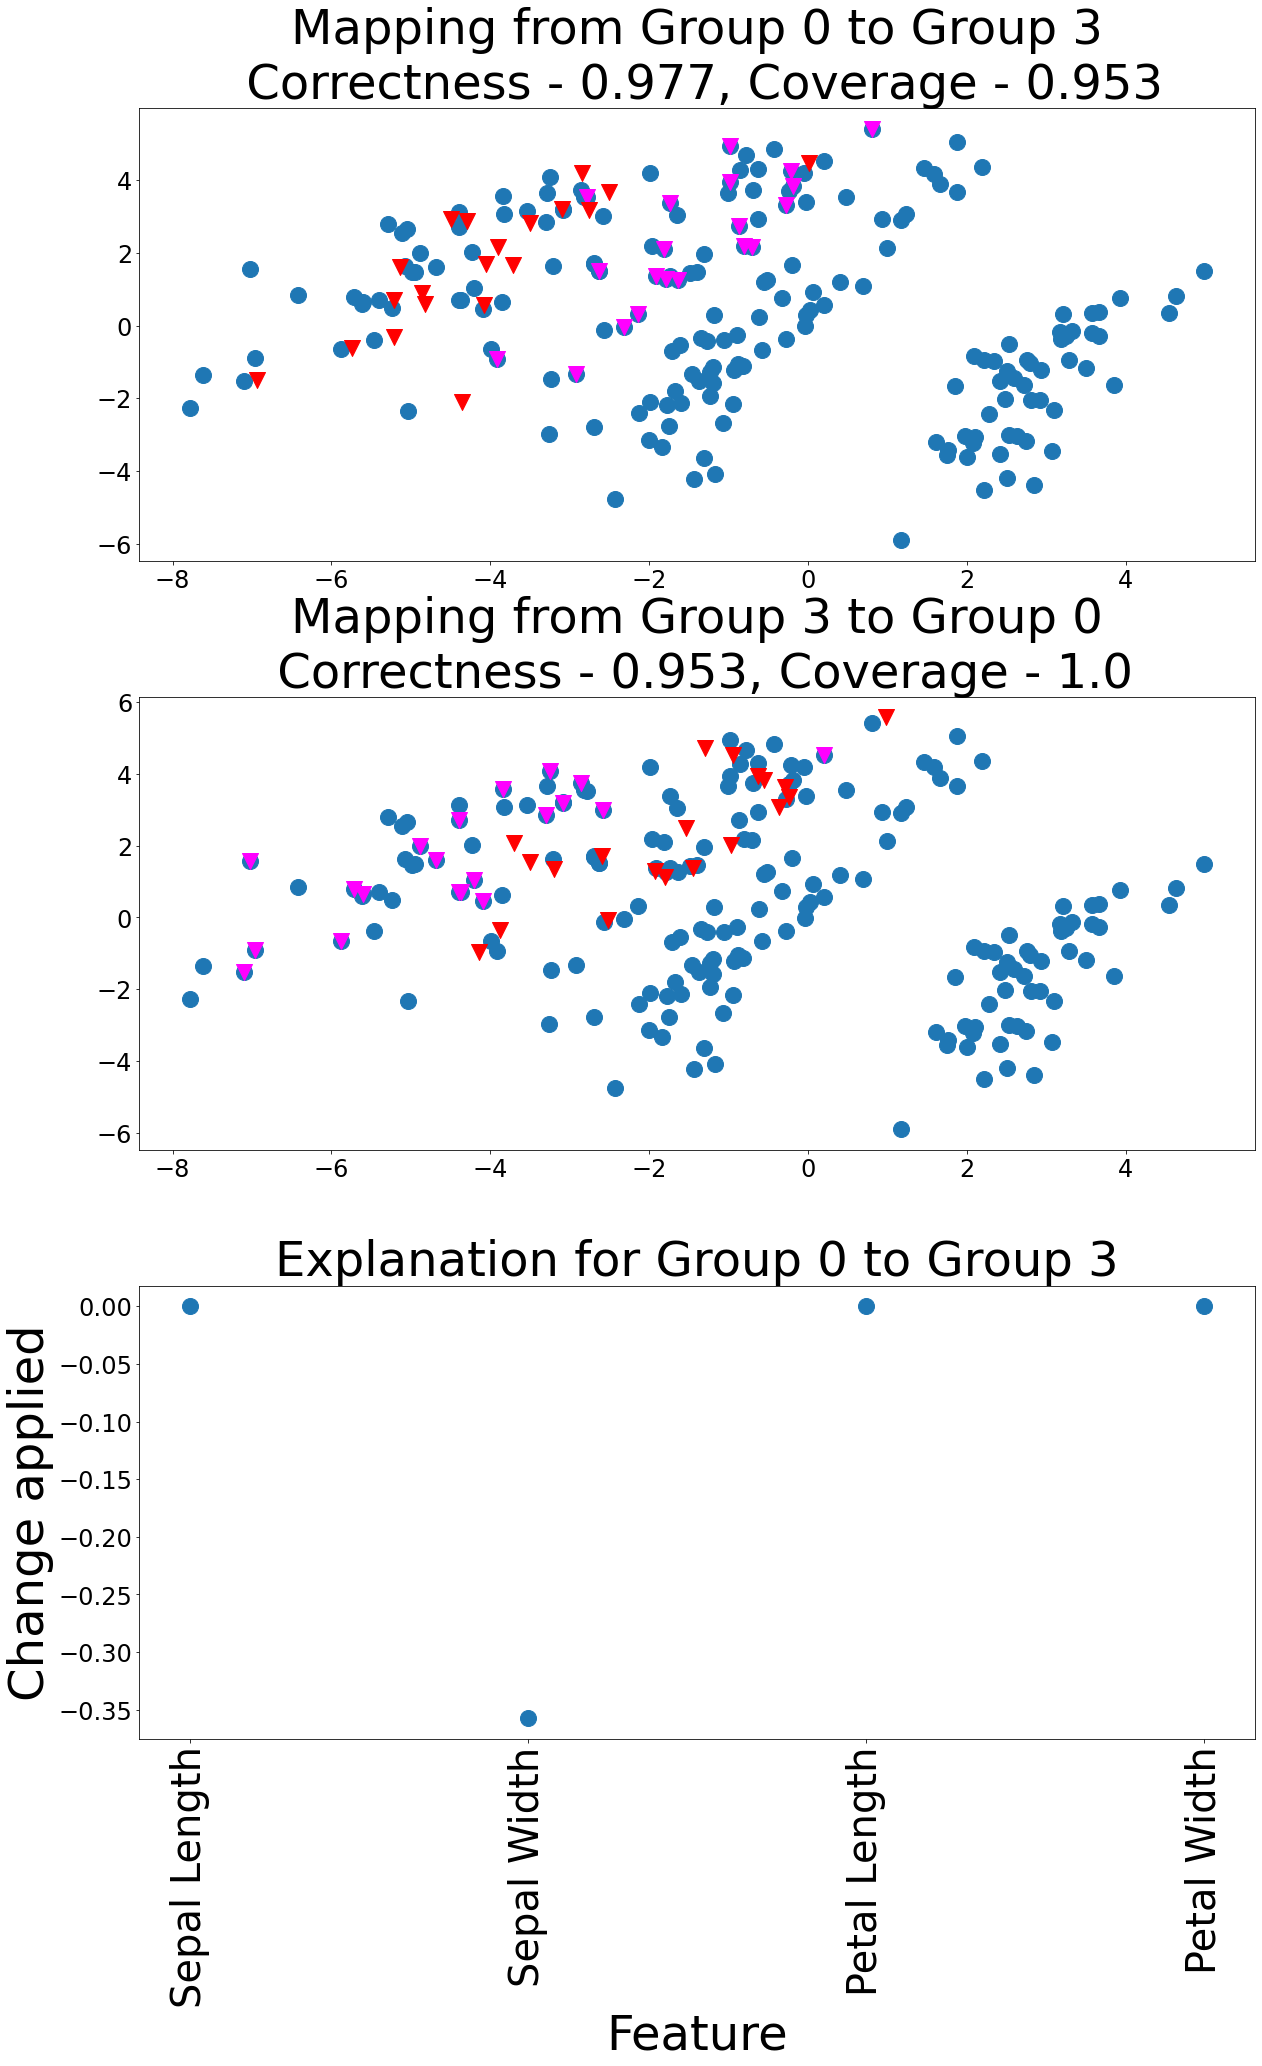

In [11]:
# Evaluate the explanations

deltas = np.load("deltas_corrupted.npy")

a, b = metrics(load_model, x_full, indices_full, deltas, epsilon, k = k)

plot_metrics(a, b, name = "iris-metrics-corrupted.png")

plot_explanation(load_model, x_full, data_rep_full, indices_full, deltas, a, b, target_corrupted, num_clusters, k = k, name = "iris-t2c.png", num_points = 20, feature_names = feature_names)


[[ 0.00943363  0.00538468 -0.01157959 -0.28412885]
 [-0.34477869  0.25905948 -0.07814478 -0.97360134]
 [-0.03374392 -0.35745492 -0.00360507  0.00827053]]
[[-0.01558736 -0.02416323 -0.02593263 -0.32019561]
 [ 0.05533863  0.11448527  0.0504016  -1.03769917]]
['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']
[[-0.02 -0.02 -0.03 -0.32]
 [ 0.06  0.11  0.05 -1.04]]
[[ 0.01  0.01 -0.01 -0.28]
 [-0.34  0.26 -0.08 -0.97]]


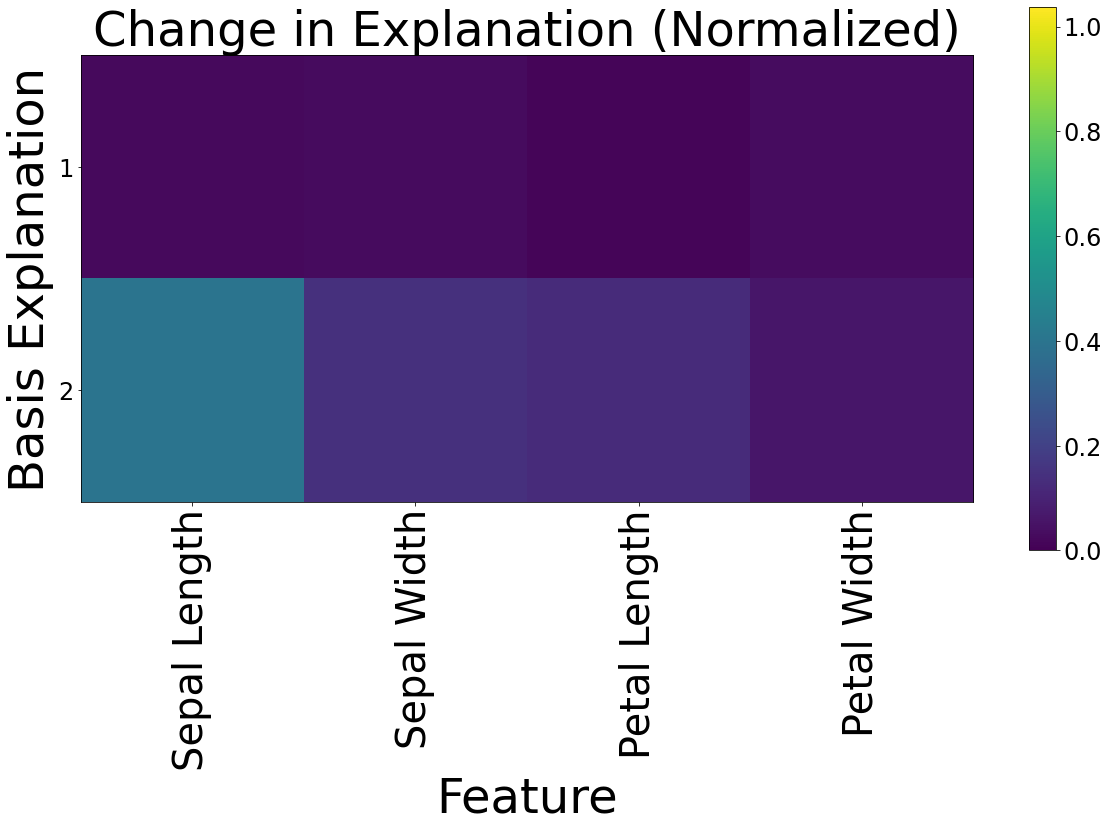

In [12]:
# Evaluate how much the other explanations changed

deltas_original = np.load("../Iris-K/deltas" + str(k) + ".npy")
print(deltas)
print(deltas_original)
print(feature_names)
plot_change(deltas, deltas_original, "iris-corrupted-similarity.png", feature_names = feature_names)
